# Unsupervised NLP
----

For this NLP project, I decided to use the 20 Newsgroups dataset.

The dataset can be found here: http://qwone.com/~jason/20Newsgroups/

The 20 Newsgroups dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.  The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other, while others are highly unrelated.

I chose 10 of the most closely related topics and I am going to try and build a classification model to predict which newsgroup a data point belongs to.

In [1]:
import numpy as np
import pandas as pd
import glob
import sklearn
import os
import nltk
import re
import scipy
import spacy
import scipy.stats as stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.cluster import SpectralClustering
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
from sklearn import ensemble
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg, stopwords
from collections import Counter
%matplotlib inline

In [2]:
english_stops = stopwords.words('english')
nlp = spacy.load('en')

### Training Set

In [3]:
path = "./data/20news-bydate/20news-bydate-train/"
df_news = pd.DataFrame(columns=['text', 'category'])

allGraphicsFiles = glob.glob(path + 'graphics' + "/*")
allWindowsMiscFiles = glob.glob(path + 'windows_misc' + "/*")
allPcHardwareFiles = glob.glob(path + 'pc_hardware' + "/*")
allMacHardwareFiles = glob.glob(path + 'mac_hardware' + "/*")
allWindowsXFiles = glob.glob(path + 'windows_x' + "/*")
allCryptFiles = glob.glob(path + 'crypt' + "/*")
allElectronicsFiles = glob.glob(path + 'electronics' + "/*")
allMedFiles = glob.glob(path + 'med' + "/*")
allSpaceFiles = glob.glob(path + 'space' + "/*")
allPoliticsFiles = glob.glob(path + 'politics' + "/*")

allFiles = (allGraphicsFiles + 
            allWindowsMiscFiles + 
            allPcHardwareFiles + 
            allMacHardwareFiles + 
            allWindowsXFiles + 
            allCryptFiles + 
            allElectronicsFiles + 
            allMedFiles + 
            allSpaceFiles + 
            allPoliticsFiles)

# for file_ in allFiles:
for idx, file_ in enumerate(allFiles):
    with open(file_, 'r', encoding='utf-8', errors='ignore') as myfile:
        data = myfile.read()
                
        # Grab label from the directory name
        labelFromDir = re.split(r'\/', allFiles[idx])[-2]     
        
        df_news = df_news.append({'text': data, 'category': labelFromDir}, ignore_index=True)

### Test set

In [4]:
path = "./data/20news-bydate/20news-bydate-test/"
df_news_test = pd.DataFrame(columns=['text', 'category'])

allGraphicsFiles = glob.glob(path + 'graphics' + "/*")
allWindowsMiscFiles = glob.glob(path + 'windows_misc' + "/*")
allPcHardwareFiles = glob.glob(path + 'pc_hardware' + "/*")
allMacHardwareFiles = glob.glob(path + 'mac_hardware' + "/*")
allWindowsXFiles = glob.glob(path + 'windows_x' + "/*")
allCryptFiles = glob.glob(path + 'crypt' + "/*")
allElectronicsFiles = glob.glob(path + 'electronics' + "/*")
allMedFiles = glob.glob(path + 'med' + "/*")
allSpaceFiles = glob.glob(path + 'space' + "/*")
allPoliticsFiles = glob.glob(path + 'politics' + "/*")

allTestFiles = (
            allGraphicsFiles + 
            allWindowsMiscFiles + 
            allPcHardwareFiles + 
            allMacHardwareFiles + 
            allWindowsXFiles + 
            allCryptFiles + 
            allElectronicsFiles +
            allMedFiles + 
            allSpaceFiles + 
            allPoliticsFiles)

# for file_ in allFiles:
for idx, file_ in enumerate(allTestFiles):
    with open(file_, 'r', encoding='utf-8', errors='ignore') as myfile:
        data = myfile.read() 
        
        # Grab label from the directory name
        labelFromDir = re.split(r'\/', allTestFiles[idx])[-2]
        
        df_news_test = df_news_test.append({'text': data, 'category': labelFromDir}, ignore_index=True)

In [5]:
# Train set
print(f'df_news.shape: {df_news.shape}')
df_news.head()

df_news.shape: (5774, 2)


,text,category
0,From: cavalier@blkbox.COM (Bill Egan)\nSubject...,graphics
1,From: ch381@cleveland.Freenet.Edu (James K. Bl...,graphics
2,From: rytg7@fel.tno.nl (Q. van Rijt)\nSubject:...,graphics
3,From: uk02183@nx10.mik.uky.edu (bryan k willia...,graphics
4,From: rschmitt@shearson.com (Robert Schmitt)\n...,graphics


In [6]:
df_news['category'].value_counts()

crypt           595
med             594
space           593
windows_x       593
electronics     591
windows_misc    591
pc_hardware     590
graphics        584
mac_hardware    578
politics        465
Name: category, dtype: int64

In [7]:
# Test set
print(f'df_news_test.shape: {df_news_test.shape}')
df_news_test.head()

df_news_test.shape: (3844, 2)


,text,category
0,From: Scott_Rindfleisch@vos.stratus.com\nSubje...,graphics
1,From: SITUNAYA@IBM3090.BHAM.AC.UK\nSubject: Be...,graphics
2,From: z_nixsp@ccsvax.sfasu.edu\nSubject: Re: T...,graphics
3,From: vax839@tid.es (Juan Carlos Cuesta Cuesta...,graphics
4,From: dts@buoy.cis.ufl.edu (Dave Small)\nSubje...,graphics


In [8]:
df_news_test['category'].value_counts()

crypt           396
med             396
windows_x       395
space           394
windows_misc    394
electronics     393
pc_hardware     392
graphics        389
mac_hardware    385
politics        310
Name: category, dtype: int64

## Preprocessing

In [9]:
def texter(text):
    # Remove special chars
    document = re.sub(r'\W', ' ', text)
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    tokens = [w for w in word_tokenize(document.lower()) 
                  if w.isalpha()]
    
    no_stops = [t for t in tokens 
                    if t not in english_stops]
    
    lemmatized = [WordNetLemmatizer().lemmatize(t) for t in no_stops]
    
    document = ' '.join(lemmatized)
    
    return document

In [10]:
# Before Preprocessing
df_news['text'][0]

"From: cavalier@blkbox.COM (Bill Egan)\nSubject: Re: Weitek P9000 ?\nNntp-Posting-Host: port3.houston.pub-ip.psi.net\nOrganization: Performance Systems Int'l\nLines: 13\n\njgreen@amber (Joe Green) writes:\n>> > Anyone know about the Weitek P9000 graphics chip?\n\n>Do you have Weitek's address/phone number?  I'd like to get some information\n>about this chip.\n\nYes, I am very interested in this chip.  Please follow up or email.\n\n--\nBill Egan          \nCavalier Graphics\nHouston, Texas\nEmail: cavalier@blkbox.com \n"

In [11]:
df_news['text'] = df_news['text'].apply(texter)
df_news_test['text'] = df_news_test['text'].apply(texter)

In [12]:
# After Preprocessing
df_news['text'][0]

'cavalier blkbox com bill egan subject weitek nntp posting host houston pub ip psi net organization performance system int line jgreen amber joe green writes anyone know weitek graphic chip weitek address phone number like get information chip yes interested chip please follow email bill egan cavalier graphic houston texas email cavalier blkbox com'

In [13]:
def mutlt_labels(row):
    if (row == 'crypt'):
        return 1
    elif (row == 'med'):
        return 2
    elif (row == 'windows_x'):
        return 3
    elif (row == 'space'):
        return 4
    elif (row == 'electronics'):
        return 5
    elif (row == 'windows_misc'):
        return 6
    elif (row == 'pc_hardware'):
        return 7
    elif (row == 'graphics'):
        return 8
    elif (row == 'mac_hardware'):
        return 9
    elif (row == 'politics'):
        return 10
    else:
        return row

In [14]:
df_news['category'] = df_news['category'].apply(mutlt_labels)
df_news_test['category'] = df_news_test['category'].apply(mutlt_labels)

In [15]:
df_news['category'].value_counts()

1     595
2     594
3     593
4     593
6     591
5     591
7     590
8     584
9     578
10    465
Name: category, dtype: int64

## BoW

In [52]:
# Initialize a CountVectorizer, min appearance of 5 docs
count_vectorizer = CountVectorizer(stop_words="english", min_df=5)

# Transform the training data
counts = count_vectorizer.fit_transform(df_news['text'].values)

# Print the first 10 features
print(count_vectorizer.get_feature_names()[0:10])

['aa', 'aaron', 'aau', 'ab', 'abad', 'abandon', 'abandoned', 'abbey', 'abbreviation', 'abc']


## TF-IDF

In [53]:
# Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=5)

# Transform the training data
tfidfs = tfidf_vectorizer.fit_transform(df_news['text'].values)

In [54]:
tfidfs.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Clustering

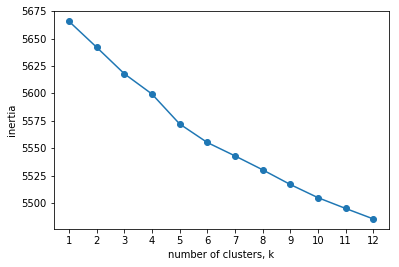

In [55]:
# Intertias
ks = range(1, 13)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tfidfs)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

It looks like the plot slightly elbows at around 6, so let's try 6 clusters.

In [59]:
km = KMeans(n_clusters=6)

# Fit model to samples
km.fit(tfidfs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [60]:
km_6_pred = km.predict(tfidfs)
metrics.adjusted_rand_score(df_news['category'].values, km_6_pred)

0.14700480080691355

## SpectralClustering

In [112]:
n_clusters=10

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(tfidfs)

# Predicted clusters
predict_sc = sc.fit_predict(tfidfs)

In [113]:
pd.crosstab(df_news['category'].values, predict_sc) 

col_0,0,1,2,3,4,5,6,7,8,9
category,,,,,,,,,,
1,9,16,214,17,0,0,1,2,187,0
2,24,0,357,0,58,0,2,4,0,0
3,50,0,228,0,0,0,158,5,4,0
4,13,0,220,0,0,0,0,212,0,0
5,141,0,282,0,0,0,3,17,0,0
6,131,0,90,0,0,0,221,1,0,0
7,287,0,101,0,0,36,16,0,2,0
8,142,0,237,0,0,0,52,7,0,0
9,324,0,97,0,0,8,2,3,0,0


In [114]:
metrics.adjusted_rand_score(y_train, predict_sc)

0.09408574389739935

Performed much worse than Kmeans

## Let's try some cleaning:  will clustering improve?

In [102]:
tfidf_df = pd.DataFrame(tfidfs.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df.head()

,aa,aaron,aau,ab,abad,abandon,abandoned,abbey,abbreviation,abc,...,zrepachol,zt,zterm,zu,zurich,zv,zw,zy,zyeh,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
convert_cat = []
to_drop = []

categorical = tfidf_df.columns

for index, feature in enumerate(categorical):

    cont = pd.crosstab(tfidf_df[feature], df_news['category'], colnames=[None])
    chi2_res = scipy.stats.chi2_contingency(cont)

    # Keep all features with a significant P-value and drop the others
    if chi2_res[1] <= 0.05:
        convert_cat.append(feature)
    else:
        to_drop.append(feature)

/Users/rook/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:135: FutureWarning: 'None' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)


In [138]:
print(f'convert_cat len: {len(convert_cat)}')
print(f'to_drop len: {len(to_drop)}')

convert_cat len: 230
to_drop len: 12195


In [139]:
# Drop cols
tfidf_df_chi2 = tfidf_df.loc[:, ~tfidf_df.columns.isin(to_drop)]

In [141]:
tfidf_df_chi2.shape

(5774, 230)

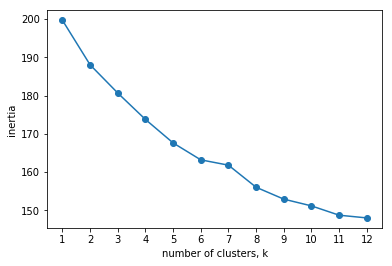

In [142]:
# Intertias
ks = range(1, 13)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tfidf_df_chi2)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [143]:
km_7 = KMeans(n_clusters=7)

# Fit model to samples
km_7.fit(tfidf_df_chi2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [144]:
km_7_pred = km_7.predict(tfidf_df_chi2)
metrics.adjusted_rand_score(df_news['category'].values, km_7_pred)

0.004232437241477186

This perforned much worse than before.

## Add cluster feature

In [102]:
tfidf_df = pd.DataFrame(tfidfs.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df.head()

,aa,aaron,aau,ab,abad,abandon,abandoned,abbey,abbreviation,abc,...,zrepachol,zt,zterm,zu,zurich,zv,zw,zy,zyeh,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
tfidf_df['cluster_number'] = km.labels_
tfidf_df.head()

,aa,aaron,aau,ab,abad,abandon,abandoned,abbey,abbreviation,abc,...,zt,zterm,zu,zurich,zv,zw,zy,zyeh,zz,cluster_number
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## Train / Test splits

In [120]:
y = df_news['category']

# Create training and test sets
X_tfidf_train, X_tfidf_val, y_tfidf_train, y_tfidf_val = train_test_split(tfidf_df, y, test_size=0.25, stratify=y, random_state=53)
X_bow_train, X_bow_val, y_bow_train, y_bow_val = train_test_split(counts, y, test_size=0.25, stratify=y, random_state=53)

# The Test data was seperate from the rest
# Test set
X_test = df_news_test['text']
y_test = df_news_test['category']

# Transform the test data
count_test = count_vectorizer.transform(X_test.values)
tfidf_test = tfidf_vectorizer.transform(X_test.values)

## Logistic Regression

In [110]:
# Instantiate
lr = LogisticRegression()

# Fit the classifier to the training data
lr.fit(X_tfidf_train, y_tfidf_train)

# Create the predicted tags: pred
pred = lr.predict(X_tfidf_val)

print('Training set score:', lr.score(X_tfidf_train, y_tfidf_train))

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_tfidf_val, pred)
print(f'\nTest set score: {score}')

# Calculate the confusion matrix: cm
pd.crosstab(y_tfidf_val, pred)

Training set score: 0.9540415704387991

Test set score: 0.8601108033240997


col_0,1,2,3,4,5,6,7,8,9,10
category,,,,,,,,,,
1,126,1,6,1,2,0,1,8,0,4
2,0,138,1,2,4,0,1,3,0,0
3,2,0,118,4,2,10,3,9,0,0
4,0,3,2,131,3,0,1,6,2,0
5,0,0,0,2,135,0,4,4,3,0
6,0,0,8,0,2,126,5,7,0,0
7,0,0,3,0,6,13,109,5,12,0
8,0,0,7,0,3,1,3,131,1,0
9,0,0,0,0,6,2,7,5,122,2


86% accuracy with a basic model is a good sign.

## Logistic Regression: GridSearch

In [114]:
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_tfidf_train, y_tfidf_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.88
Best parameters:  {'C': 10}


## Remove clustering feature

In [116]:
X_tfidf_train = X_tfidf_train.loc[:, ~X_tfidf_train.columns.isin(['cluster_number'])]
X_tfidf_val = X_tfidf_val.loc[:, ~X_tfidf_val.columns.isin(['cluster_number'])]

In [118]:
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_tfidf_train, y_tfidf_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.89
Best parameters:  {'C': 10}


The models actually perform better without the clustering feature.  This is not surprising though, considering the low ARI.

## Logistic Regression: BoW

In [128]:
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_bow_train, y_bow_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.87
Best parameters:  {'C': 0.1}


Did not perform as well as the tf-idf features.

## Logistic Regression: ngrams

In [77]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression()) # running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams

param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10],
                  "tfidfvectorizer__ngram_range": [(1, 1), (1, 2)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.89
Best parameters:
{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 2)}


No improvement in accuracy over the best td-idf model so far.

## Random Forest

In [94]:
rfc = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1)
rfc.fit(X_tfidf_train, y_tfidf_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [95]:
# Create the predicted tags: pred
pred = rfc.predict(X_tfidf_val)

print('Training set score:', rfc.score(X_tfidf_train, y_tfidf_train))

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_tfidf_val, pred)
print(f'\nTest set score: {score}')

Training set score: 1.0

Test set score: 0.824792243767313


## Random Forest: GridSearch

In [96]:
parameters = {'n_estimators':[100,300,500],
              'max_features':['sqrt', 'log2'],
              'min_samples_split':[2,8,20]
             }

# Instantiating and fitting Grid Search, then printing best score and best parameters
grid_rfc = GridSearchCV(ensemble.RandomForestClassifier(), param_grid=parameters, cv=5, n_jobs=2)
grid_rfc.fit(X_tfidf_train, y_tfidf_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_estimators': [100, 300, 500], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 8, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [97]:
print("Best cross-validation score: {:.2f}".format(grid_rfc.best_score_))
print("Best parameters:\n{}".format(grid_rfc.best_params_))

Best cross-validation score: 0.88
Best parameters:
{'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 500}


Logistic regression had the highest accuracy.

## Test Set

In [129]:
# Instantiate
lr_final = LogisticRegression(C=10, multi_class='ovr')

# Fit the classifier to the training data
lr_final.fit(X_tfidf_train, y_tfidf_train)

pred_test = lr_final.predict(tfidf_test)

# Calculate the accuracy score: score
score_test = metrics.accuracy_score(y_test, pred_test)
print(f'\nTest set score: {score_test}')


Test set score: 0.8223204994797086


In [130]:
# Confusion matrix
pd.crosstab(y_test, pred_test)

col_0,1,2,3,4,5,6,7,8,9,10
category,,,,,,,,,,
1,361,0,3,2,7,3,2,6,5,7
2,1,344,6,3,12,4,5,8,3,10
3,0,1,301,3,4,29,6,47,4,0
4,0,8,2,361,5,1,0,10,2,5
5,8,7,0,4,316,10,28,9,11,0
6,3,3,24,3,3,280,30,24,17,7
7,0,2,9,3,23,27,285,10,33,0
8,4,5,18,7,16,14,10,306,8,1
9,1,1,2,1,15,9,21,6,328,1


## Clustering Test Set

In [131]:
km_6_test = KMeans(n_clusters=6)

# Fit model to samples
km_6_test.fit(tfidf_test)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [132]:
km_6_pred_test = km_6_test.predict(tfidf_test)
pd.crosstab(y_test, km_6_pred_test) 

col_0,0,1,2,3,4,5,6,8,9
category,,,,,,,,,
1,0,134,22,1,1,1,84,0,153
2,3,244,11,1,1,0,136,0,0
3,1,7,58,84,9,3,230,0,3
4,2,142,13,0,154,0,82,1,0
5,0,36,21,0,9,5,313,6,3
6,7,20,33,174,1,41,104,13,1
7,9,11,15,5,3,72,204,73,0
8,4,13,120,2,5,18,227,0,0
9,7,6,6,1,3,35,284,43,0


In [134]:
metrics.adjusted_rand_score(y_test, km_10_pred_test)

0.11710507071345574

Not great.  Similar results to the clustering of the training set.

# Conclusion
---

Explain how clustering and modeling compare for classifying your texts.  What are the advantages of each? Why would you want to use one over the other?
--------

Clustering suggests groupings based on patterns in the data.  These groupings are typically formed on the basis of similarity.  For example, books written by the same author would be clustered together.  Clustering can uncover patterns in the data that can be used for inference or for feature engineering purposes.  The biggest difference between clustering and classification if that clustering can work without labels.

With a classification problem, you typically have a set of predefined classes and you want to know which class a new object belongs to.  With NLP problems, you’re typically dealing with a wide dataset given the corpus of words from the documents.  This can make clustering a computationally expensive process.

It boils down to what you’re trying to accomplish.  If you simply want a model to accurately predict what type of genre a book falls under and you have a labeled dataset to train on, then I would go with a classification model.  If you’re intent is to provide book recommendation, then clustering could potentially be beneficial because it would allow you to see what books are similar to others.  The two do not have to be mutually exclusive.

For this use case and with this dataset, I had a difficult time getting a clustering algorithm to perform well but I was able to achieve a test accuracy of 82% using logistic regression.